In [0]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision torchtext
import torch

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
!python -m spacy download en

#####################################################
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()
######################################################

# WHAT YOU NEED TO DO
# This piece of code will install everything to colab.However, you need to upload the csv files to your drive
# to the My Drive/Colab Notebooks/data/' path. When you run this part, it will ask you to connect your own google drive
# so you will need to give access to it - it seems i can't share my drive through Colab unfortunately

# Copy MovieLens data to following location: 'My Drive/Colab Notebooks/data/MovieLens-Small/ratings.csv'

Mounted at /content/gdrive

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

Gen RAM Free: 11.8 GB  | Proc size: 1.8 GB
GPU RAM Free: 11062MB | Used: 379MB | Util   3% | Total 11441MB


In [0]:
# DATA

import pandas as pd
import numpy as np
import os
from torchtext import data, vocab
import torch
from random import randint

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class MovieLens:
    """
    Class to handle the MovieLens data
    """

    def __init__(self, device, path='./gdrive/My Drive/Colab Notebooks/data/MovieLens-Small/ratings.csv'):
        print('Device: ' + str(device))

        self.user = data.Field(sequential=False, use_vocab=True)
        self.movie = data.Field(sequential=False, use_vocab=True)
        self.rating = data.Field(sequential=False, use_vocab=False, dtype=torch.float)

        self.train_set, self.validation_set, self.test_set = data.TabularDataset(
            path=path,
            format='csv',
            fields=[('user', self.user), ('movie', self.movie), ('rating', self.rating), ('timestamp', None)],
            skip_header=True,
        ).split(split_ratio=[0.7, 0.15, 0.15])

        self.train_iter, self.validation_iter, self.test_iter = data.BucketIterator.splits(
            (self.train_set, self.validation_set, self.test_set),
            batch_size=100,
            device=device,
            sort_key=lambda x: len(x.movie),
            repeat=True)

        self.user.build_vocab(self.train_set)
        self.movie.build_vocab(self.train_set)

In [0]:
# MODEL
import torch
import torch.nn as nn
import numpy as np
import torch.nn.utils.rnn as rnn
from torch.autograd import Variable


max_rating = 5.0
min_rating = 0.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class EmbeddingDot(nn.Module):
    def __init__(self, user_field, movie_field, n_factors):
        super().__init__()
        self.user_field = user_field
        self.movie_field = movie_field

        n_users = len(self.user_field.vocab.freqs) #610
        n_movies =  len(self.movie_field.vocab.freqs)# 9742

        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0, 0.05)
        self.m.weight.data.uniform_(0, 0.05)

        print(self)

    def get_movie_embedding(self, movies):
            ## easy example:
            # lookup_tensor = torch.tensor([self.movie_field.vocab.stoi['22']], dtype=torch.long)
            # lookup_tensor = lookup_tensor.to(device)
            # specific_embedding = self.m(lookup_tensor)
            # specific_embedding = specific_embedding.to(device)

            movies_np_batch = movies.cpu().data.numpy()  # convert movie-batch(torch-tensor) to numpy
            nr_rows = np.size(movies_np_batch)
            # initialize lookup-array
            lookup_np_batch = np.zeros(nr_rows, dtype=np.int)
            for idx, movie in enumerate(movies_np_batch):
                lookup_np_batch[idx] = self.movie_field.vocab.stoi[str(movie)]  # create lookuparray
            lookup_tensor_batch = torch.from_numpy(lookup_np_batch).to(device)  # convert lookup to torch tensor
            emb_batch = self.m(lookup_tensor_batch).to(device)
            return emb_batch

    def get_user_embedding(self, users):
            users_np_batch = users.cpu().data.numpy()  # convert users-batch(torch-tensor) to numpy
            nr_rows = np.size(users_np_batch)
            # initialize lookup-array
            lookup_np_batch = np.zeros(nr_rows, dtype=np.int)
            for idx, user in enumerate(users_np_batch):
                lookup_np_batch[idx] = self.user_field.vocab.stoi[str(user)]  # create lookuparray
            lookup_tensor_batch = torch.from_numpy(lookup_np_batch).to(device)  # convert lookup to torch tensor
            emb_batch = self.m(lookup_tensor_batch).to(device)
            return emb_batch

    def forward(self, batch):
        user_emb = self.get_user_embedding(batch.user)
        movie_emb = self.get_movie_embedding(batch.movie)
        res = (user_emb * movie_emb).sum(1)
        return res


In [0]:
# TRAINING

from types import SimpleNamespace
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from random import randint

def movie_lens_train(train_iter, val_iter, net, test_iter, optimizer, criterion, num_epochs=5):
    train_loss, train_accs, train_length = [0, 0, 0]
    matrix_train_error = []
    matrix_train_accs = []
    matrix_val_error = []
    matrix_val_accs = []

    for i in range(num_epochs):
        net.train()

        for batch in train_iter:
            if i != train_iter.epoch:
                break
            output = net(batch)
            batch_loss = criterion(output.reshape(-1), batch.rating)
            train_loss += batch_loss
            train_accs += accuracy(output, batch.rating)  # * batch.batch_size

            #optimization step
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()


        # print results after each epoch
        train_loss /= train_iter._iterations_this_epoch #705 #train_length
        train_loss /= 4.5 #normalize to maximum error
        train_accs /= train_iter._iterations_this_epoch #705 #train_length

        print("Epoch {}: Train loss: {:.4f},  Train accs: {:.4f}".format(i + 1, train_loss, train_accs))

        # save data in matrix
        matrix_train_error.append(train_loss)
        matrix_train_accs.append(train_accs)

        train_loss, train_accs, train_length = [0, 0, 0]

        net.eval()
        val_loss, val_accs, val_length = [0, 0, 0]

        for val_batch in val_iter:
            if i != val_iter.epoch:
                break
            val_output = net(val_batch)
            val_batch_loss = criterion(val_output.reshape(-1), val_batch.rating)
            val_loss += val_batch_loss
            val_accs += accuracy(val_output, val_batch.rating) #* val_batch.batch_size

        # print results after each epoch
        val_loss /= val_iter._iterations_this_epoch  #val_length
        val_loss /= 4.5
        val_accs /= val_iter._iterations_this_epoch  #val_length
        print("Epoch {}: Val loss: {:.4f},  Val accs:{:.4f} ".format(i + 1, val_loss, val_accs))

        # save data in matrix
        matrix_val_error.append(val_loss)
        matrix_val_accs.append(val_accs)

        val_loss, val_accs, val_length = [0, 0, 0]

        if i == (num_epochs-1):
            print('Maximum number of Epochs reached')
            break
    return matrix_train_error, matrix_train_accs, matrix_val_error, matrix_val_accs

def accuracy(output, target):
    return np.sum(torch.mean(torch.lt(torch.abs(output-target), 0.5).float()).cpu().data.numpy())

def get_numpy(loss):
    return loss.cpu().data.numpy()


In [0]:
#MAIN

import torch
from torch import optim, nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

movie_data = MovieLens(device=device)
user_field = movie_data.user
movie_field = movie_data.movie

train_set = movie_data.train_iter
test_set = movie_data.test_iter
validation_set = movie_data.validation_iter

net = EmbeddingDot(user_field, movie_field, n_factors=10).to(device)
opt = optim.SGD(net.parameters(), lr=1e-1, weight_decay=1e-5, momentum=0.9)

criterion = nn.L1Loss()

matrix_train_error, matrix_train_accs, matrix_val_error, matrix_val_accs = movie_lens_train(train_iter=train_set, test_iter=test_set, val_iter=validation_set,
      net=net, optimizer=opt, criterion=criterion, num_epochs=30)

Device: cuda:0
EmbeddingDot(
  (u): Embedding(610, 10)
  (m): Embedding(8551, 10)
)
Epoch 1: Train loss: 0.6354,  Train accs: 0.0901
Epoch 1: Val loss: 0.5643,  Val accs:0.1288 
Epoch 2: Train loss: 0.5201,  Train accs: 0.1315
Epoch 2: Val loss: 0.4082,  Val accs:0.1725 
Epoch 3: Train loss: 0.3439,  Train accs: 0.2300
Epoch 3: Val loss: 0.2840,  Val accs:0.2877 
Epoch 4: Train loss: 0.2696,  Train accs: 0.3078
Epoch 4: Val loss: 0.2422,  Val accs:0.3428 
Epoch 5: Train loss: 0.2378,  Train accs: 0.3502
Epoch 5: Val loss: 0.2218,  Val accs:0.3645 
Epoch 6: Train loss: 0.2204,  Train accs: 0.3731
Epoch 6: Val loss: 0.2088,  Val accs:0.3833 
Epoch 7: Train loss: 0.2081,  Train accs: 0.3905
Epoch 7: Val loss: 0.1993,  Val accs:0.3905 
Epoch 8: Train loss: 0.1994,  Train accs: 0.4007
Epoch 8: Val loss: 0.1928,  Val accs:0.4055 
Epoch 9: Train loss: 0.1929,  Train accs: 0.4138
Epoch 9: Val loss: 0.1877,  Val accs:0.4128 
Epoch 10: Train loss: 0.1874,  Train accs: 0.4206
Epoch 10: Val loss: 

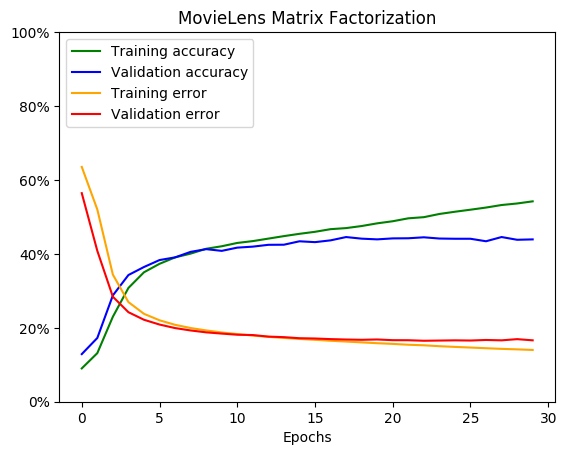

In [0]:
# Visualization

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.style.use('default')

def getPerc(array):
  return [item*100.0 for item in array]

simple = []
epochs = range(len(matrix_train_accs))

plt.plot(epochs, getPerc(matrix_train_accs), 'green', label='Training accuracy')
plt.plot(epochs, getPerc(matrix_val_accs), 'blue', label='Validation accuracy')


plt.plot(epochs, getPerc(matrix_train_error), 'orange', label='Training error')
plt.plot(epochs, getPerc(matrix_val_error), 'red', label='Validation error')


plt.legend(loc='upper left')
plt.title("MovieLens Matrix Factorization")
plt.xlabel('Epochs')
plt.ylim(0,100)

#plt.yaxis.set_major_formatter(FuncFormatter(lambda x, p: '{}%'.format(x)))

plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.show()
#plt.savefig('destination_path.eps', format='eps', dpi=1000)